## Modules Used

In [20]:
# Modules used to connect to coppelia
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [21]:
# Other Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tabulate import tabulate
import os
import networkx as nx
from copy import deepcopy

# Testing

### How to load the Image

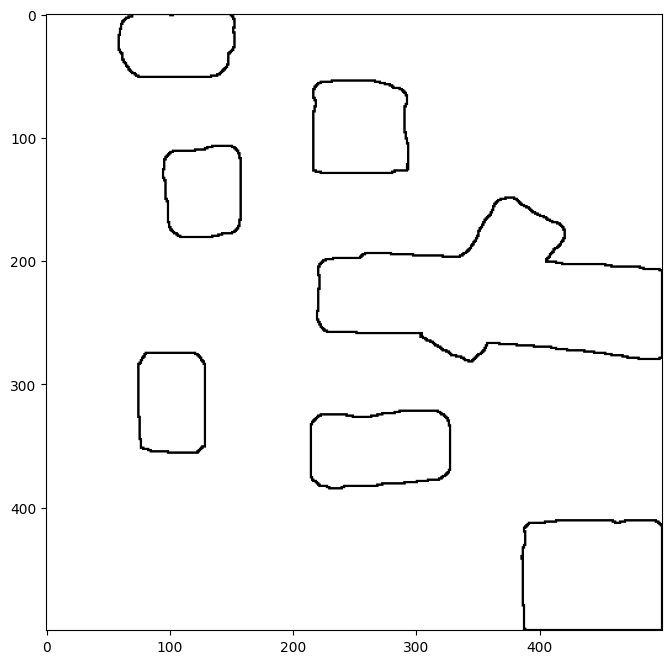

In [22]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')


# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('mapas/cave.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

### Discretizes the environment

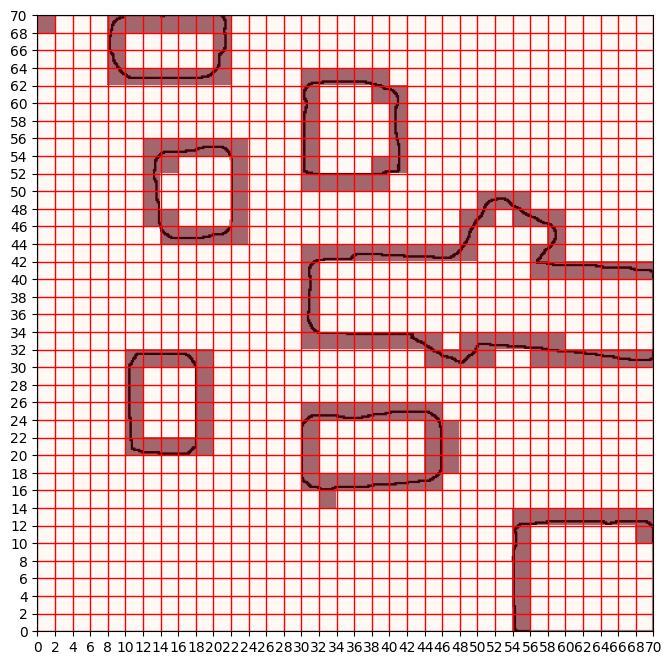

In [23]:
# Dimensões do mapa informado em metros (X, Y)
# Isso vai depender do tamanho da cena no coppelia
map_dims = np.array([70, 70]) # Cave 


# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2 # Extremamente Importante esse valor

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))


# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        # c*cell -> inicio da celula no mapa real (em metros)
        # sx -> Escala
        # c*cell*sx -> o inicio da celula porem na representação do mapa (pixel)
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])

# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0 

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

x= 0


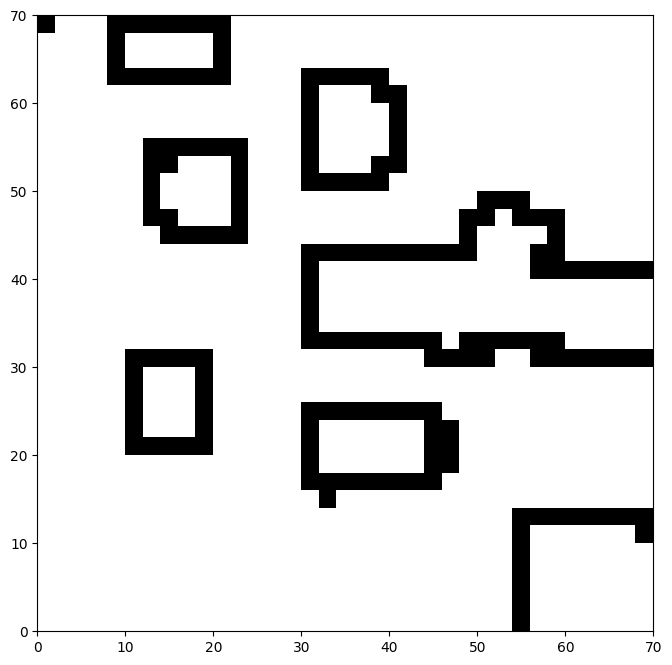

In [24]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

### Create a Wavefront

In [25]:
# Esse vetor de posição considera em quais visinhos o robô pode ir 
# Leva em consideração os 8 vizinhos
# pos = [(1,1), (1,0), (1,-1), (0,-1), (0, 1), (-1,-1), (-1, 0), (-1, 1)]

# Leva em consideração 4 vizinhos (cima, baixo, direita e esqueda)
pos = [(1, 0), (-1, 0), (0, 1), (0, -1)]

Onde tem obstaculo coloca o valor como infinito

In [26]:
# Pega os dados do grid
wave = grid
nRows, nCols = wave.shape

for r in range(nRows):
    for c in range(nCols):
        # Lugares que tem obstáculo coloca como infinito
        wave[r][c] = np.Inf if wave[r][c] == 1 else -1 

wave

array([[inf, -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

Função que cria o wavefront dado um objetivo

In [27]:
def cellNeighbors(M, cell:tuple, queue:list, pos:list):
    x, y = cell
    actualCost = M[x][y]

    nRows, nCols = M.shape

    for p in pos:
        dx, dy = p

        # Verifica os limites
        if (x + dx < 0 or y + dy < 0): continue
        if (x + dx >= nRows or y + dy >= nCols): continue
        
        # Pega o valor da celula vizinha
        neighborC = M[x + dx][y + dy]
        
        # Se vizinho é um obstáculo
        if neighborC == np.Inf: continue
        
        # Se o vizinho nunca foi explorado anteriormente
        # Coloca ele na fila (queue)
        if neighborC == -1:
            M[x + dx][y + dy] = actualCost + 1
            queue.append((x + dx, y + dy))
        
        if neighborC > actualCost:
            M[x + dx][y + dy] = actualCost + 1


In [28]:
def waveFront(M, goal, pos):
    M[goal[0]][goal[1]] = 0
    queue = [goal]
    
    while len(queue) != 0:
        cell = queue.pop(0)
        cellNeighbors(M, cell, queue, pos)
    

In [29]:
new_wave = deepcopy(wave)
goal = (34, 15)
waveFront(new_wave, goal, pos)


Text(14.75, 33.75, 'G')

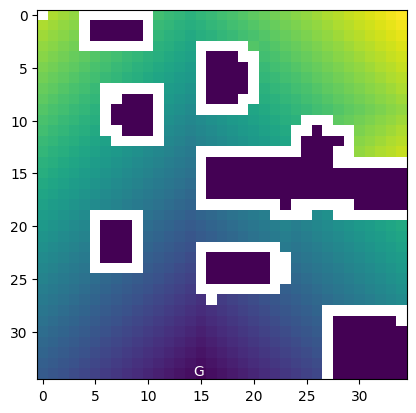

In [37]:
plt.imshow( new_wave ) 
plt.annotate('G', xy=(goal[1]-0.25, goal[0]-0.25), 
                    ha='center', va='center', color='white') 

### Planning the path

In [31]:
def nextPos(M, actualPos:tuple, pos: list):
    x, y = actualPos
    nRows, nCols = M.shape

    neighborsCost = []

    for p in pos:
        dx, dy = p

        # Verifica os limites
        if (x + dx < 0 or y + dy < 0): continue
        if (x + dx >= nRows or y + dy >= nCols): continue
        
        # Pega o valor da celula vizinha
        neighborC = M[x + dx][y + dy]
        
        # Se vizinho é um obstáculo
        if neighborC == np.Inf: continue
        
        # Adiciona o custo e posição desse vizinho no vetor
        neighborsCost.append((neighborC, (x+dx, y+dy)))

    # Acha o vizinho com custo minimo
    _, neighborPos = min(neighborsCost)

    return neighborPos
    


In [52]:
def waveFrontPathPlanning(wave, start_point:tuple, pos:list):
    count = 0
    
    actualPos = start_point
    # actualPos = plotPoint(wave, actualPos)
    while(wave[actualPos[0]][actualPos[1]] != 0):
        # Desenha o Caminho que o robo vai fazer
        plt.annotate('°', xy=(actualPos[1], actualPos[0]+0.35), 
                    ha='center', va='center', color='white') 
        actualPos = nextPos(wave, actualPos, pos)
        # actualPos = plotPoint(wave, actualPos)
        count += 1
    
    print(count)

55


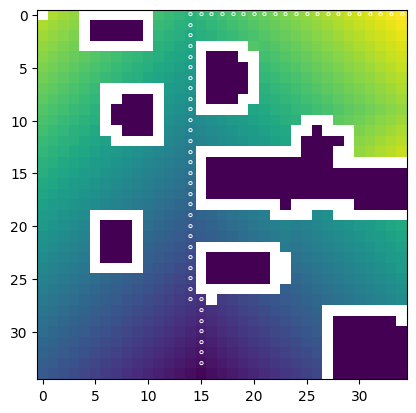

In [53]:
start = (0, 34)
wave_plus_path = deepcopy(new_wave)
# print(wave_plus_path[0][34])
plt.imshow( wave_plus_path ) 
waveFrontPathPlanning(wave_plus_path, start, pos)


### Controller

#### Testing with teacher's code

In [73]:
# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()
# DO SOME STUFF
sim.stopSimulation()

In [74]:
sim.startSimulation()

# Handle do Robô
robotname = '/Pioneer_p3dx'
robotHandle = sim.getObject(robotname)

# Handle para as juntas das RODAS
robotLeftMotorHandle = sim.getObject(robotname + '_leftMotor')
robotRightMotorHandle = sim.getObject(robotname + '_rightMotor')    

#Posição e Orientação do Robô
robotPos = sim.getObjectPosition(robotHandle)
robotOri = sim.getObjectOrientation(robotHandle)

# Goal position (x, y)
# pgoal = [2, -2]
pgoal = [0, 0]
# pgoal = [5, 5]


# Frame que representa o Goal
goalFrame = sim.getObject('/Goal')     
sim.setObjectPosition(goalFrame, [pgoal[0], pgoal[1], 0])
sim.setObjectOrientation(goalFrame, [0, 0, 0])

# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)

rho = np.inf
while rho > .05:
    #Posição e Orientação do Robô
    robotPos = sim.getObjectPosition(robotHandle)
    robotOri = sim.getObjectOrientation(robotHandle)
    robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])        
    
    dx, dy = pgoal - robotConfig[:2]
    
    # Apenas para interromper o loop
    rho = np.sqrt(dx**2 + dy**2)
            
    kr = 1
    kt = 2
    
    v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
    w = kt*(np.arctan2(dy,dx) - robotConfig[2])
            
    # Limit v,w to +/- max
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw)        
    
    vr = ((2.0*v) + (w*L))/(2.0*r)
    vl = ((2.0*v) - (w*L))/(2.0*r)

    # Enviando velocidades
    sim.setJointTargetVelocity(robotRightMotorHandle, vr)
    sim.setJointTargetVelocity(robotLeftMotorHandle, vl)    
    

sim.setJointTargetVelocity(robotRightMotorHandle, 0)
sim.setJointTargetVelocity(robotLeftMotorHandle, 0)

sim.stopSimulation()

#### Função que realiza o controle
- Input -> Recebe como input uma posição
- Output -> Leva o robo até a posição

In [75]:
robotname = '/Pioneer_p3dx'
robotHandle = sim.getObject(robotname)

# Handle para as juntas das RODAS
robotLeftMotorHandle = sim.getObject(robotname + '_leftMotor')
robotRightMotorHandle = sim.getObject(robotname + '_rightMotor')    

# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)

In [76]:
def controller(pgoal):
    # Frame que representa o Goal
    goalFrame = sim.getObject('/Goal')     
    sim.setObjectPosition(goalFrame, [pgoal[0], pgoal[1], 0])
    sim.setObjectOrientation(goalFrame, [0, 0, 0])
    
    rho = np.inf
    while rho > .05:
        #Posição e Orientação do Robô
        robotPos = sim.getObjectPosition(robotHandle)
        robotOri = sim.getObjectOrientation(robotHandle)
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])        
        
        dx, dy = pgoal - robotConfig[:2]
        
        # Apenas para interromper o loop
        rho = np.sqrt(dx**2 + dy**2)
                
        kr = 1
        kt = 2
        
        v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(dy,dx) - robotConfig[2])
                
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)

        # Enviando velocidades
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl)    

    # Para os motores
    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)

### Integrando o Controle com o Planejamento

#### Controle

Informações do Robô

In [77]:
robotname = '/Pioneer_p3dx'
robotHandle = sim.getObject(robotname)

# Handle para as juntas das RODAS
robotLeftMotorHandle = sim.getObject(robotname + '_leftMotor')
robotRightMotorHandle = sim.getObject(robotname + '_rightMotor')    

# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)

Função de Controle

In [78]:
def controller(pgoal):
    # Frame que representa o Goal
    goalFrame = sim.getObject('/Goal')     
    sim.setObjectPosition(goalFrame, [pgoal[0], pgoal[1], 0])
    sim.setObjectOrientation(goalFrame, [0, 0, 0])
    
    rho = np.inf
    while rho > .05:
        #Posição e Orientação do Robô
        robotPos = sim.getObjectPosition(robotHandle)
        robotOri = sim.getObjectOrientation(robotHandle)
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])        
        
        dx, dy = pgoal - robotConfig[:2]
        
        # Apenas para interromper o loop
        rho = np.sqrt(dx**2 + dy**2)
                
        kr = 1
        kt = 2
        
        v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(dy,dx) - robotConfig[2])
                
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)

        # Enviando velocidades
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl)    

    # Para os motores
    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)

#### Planejamento de Caminho

Abre a imagem que representa o mapa que o robô terá que navegar

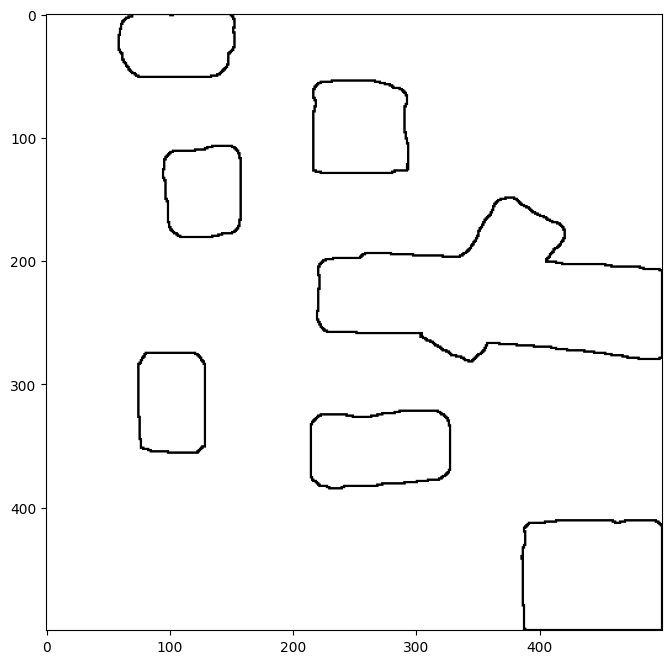

In [79]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')


# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('mapas/cave.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

Função que Discretiza o Ambiente

In [ ]:
# Dimensões do mapa informado em metros (X, Y)
# Isso vai depender do tamanho da cena no coppelia
map_dims = np.array([70, 70]) # Cave 

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2 # Extremamente Importante esse valor

# img -> Uma matriz numpy da Imagem
# map_dims -> Dimensões do mapa informado em metros (X, Y)
# cell_size -> Tamanho da célula do nosso Grid (em metros)
def discretizesTheEnvironment(img, map_dims, cell_size):

    # Escala Pixel/Metro
    sy, sx = img.shape / map_dims

    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))


    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):
            
            # c*cell -> inicio da celula no mapa real (em metros)
            # sx -> Escala
            # c*cell*sx -> o inicio da celula porem na representação do mapa (pixel)
            xi = int(c*cell_size*sx)
            xf = int(xi + cell_size*sx)
            
            yi = int(r*cell_size*sy)
            yf = int(yi + cell_size*sy)
                        
            grid[r, c] = np.sum(img[yi:yf,xi:xf])

    # Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > threshold] = 1
    grid[grid<= threshold] = 0 

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))
